In [40]:
# ---------------------------------------
# IMPORTS
# ---------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [41]:
# ----------------------------
# TRANSFORMS (Data Augmentation)
# ----------------------------
train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(150, scale=(0.9,1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

# ----------------------------
# DATASET PATHS
# ----------------------------
train_dir = r"D:\MCA\5_Trimester\Neural Network and Deep Learning\dataset\seg_pred\seg_pred"
test_dir  = r"D:\MCA\5_Trimester\Neural Network and Deep Learning\dataset\seg_test\seg_test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


FileNotFoundError: Couldn't find any class folder in D:\MCA\5_Trimester\Neural Network and Deep Learning\dataset\seg_pred\seg_pred.

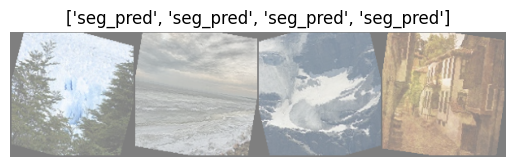

In [28]:
# Visualizing samples
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis("off")

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]), [classes[l] for l in labels[:4]])

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 9 * 9, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
model = CNN().to(device)
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [31]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = running_loss / len(test_loader)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

Epoch [1/10] | Train Acc: 99.56% | Test Acc: 100.00%
Epoch [2/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [3/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [4/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [5/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [6/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [7/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [8/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [9/10] | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [10/10] | Train Acc: 100.00% | Test Acc: 100.00%


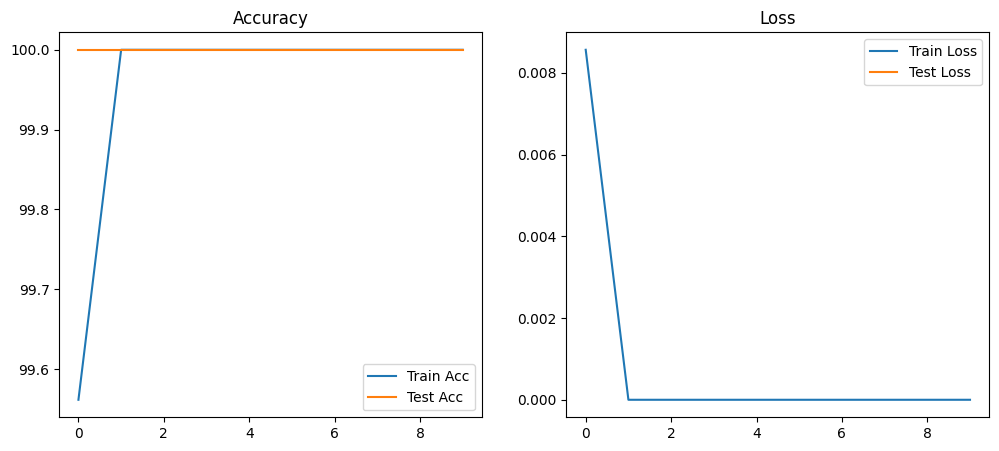

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(test_acc_list, label="Test Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.legend()
plt.title("Loss")
plt.show()

d:\MCA\5_Trimester\Neural Network and Deep Learning\torchgpu\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


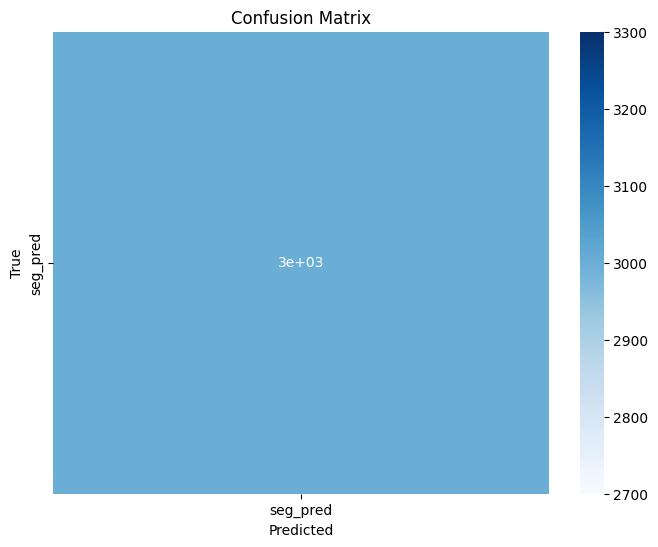

In [33]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [34]:
torch.save(model.state_dict(), "intel_cnn_pytorch.pth")
print("Model saved!")

Model saved!


In [35]:
model = CNN().to(device)
model.load_state_dict(torch.load("intel_cnn_pytorch.pth"))
model.eval()

C:\Users\ajing\AppData\Local\Temp\ipykernel_17800\2047104855.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("intel_cnn_pytorch.pth"))


CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [36]:
print("Class order:", train_dataset.classes)

Class order: ['seg_pred']


In [37]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   # <- IMPORTANT


d:\MCA\5_Trimester\Neural Network and Deep Learning\torchgpu\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


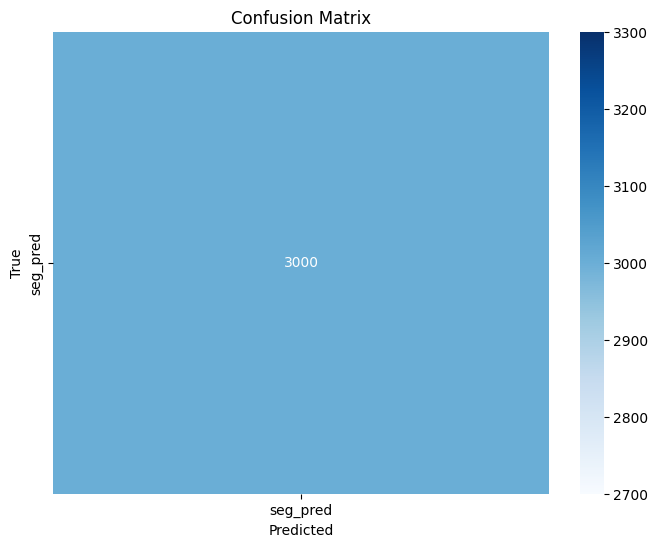

In [38]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [39]:
print("Train classes:", train_dataset.classes)
print("Test  classes:", test_dataset.classes)

Train classes: ['seg_pred']
Test  classes: ['seg_test']
